In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [57]:
def torch_randnorm(size, dim=0):
    # Generate a random tensor
    rand_tensor = torch.rand(size)
    
    # Normalize along the specified dimension
    sum_along_dim = torch.sum(rand_tensor, dim=dim, keepdim=True)
    normalized_tensor = rand_tensor / sum_along_dim
    
    return normalized_tensor

# Example usage
normalized_tensor = torch_randnorm([5,6], dim=1)
print(normalized_tensor)
print(normalized_tensor.sum(dim=1))

tensor([[0.0008, 0.0941, 0.2450, 0.0742, 0.3576, 0.2284],
        [0.0149, 0.3803, 0.1155, 0.0790, 0.1815, 0.2288],
        [0.3407, 0.0017, 0.1118, 0.1144, 0.2864, 0.1450],
        [0.2184, 0.1328, 0.0070, 0.0006, 0.2337, 0.4075],
        [0.0567, 0.2291, 0.2649, 0.0764, 0.1468, 0.2261]])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [58]:
class NeuralCoilLayer(nn.Module):
    def __init__(self, n_features):
        super(NeuralCoilLayer, self).__init__()
        self.n_features = n_features
        self.attention_weights = nn.Linear(n_features, 1, bias=False)
        self.act = nn.SiLU()
        self.interaction_tensors = nn.Parameter(torch.randn(n_features, n_features, n_features, n_features + 1))
        self.topk_num = 1
        
    def step_coil(self, state_tensor, previous_transition_tensor):
        # Establish normalized subgroups
        norm_subgroups = torch.cat((state_tensor.unsqueeze(-2), previous_transition_tensor), dim=1)
        batch_size, num_groups, n_features = norm_subgroups.shape
        
        # Compute scores for each normalized subgroup
        scores = self.act(self.attention_weights(norm_subgroups)).sum(-1) # [batch_size, num_groups]
        
        weights = torch.softmax(scores,dim = -1) # [batch_size, num_groups]
        
        selected_interaction_tensors = self.interaction_tensors
        selected_norm_subgroups = norm_subgroups

        #selected_transition_tensors = torch.einsum('ijks,bsi->bjks', selected_interaction_tensors, selected_norm_subgroups)
        
        selected_transition_tensors = (torch.mul(selected_interaction_tensors, selected_norm_subgroups.permute(0,2,1).unsqueeze(1).unsqueeze(1))).sum(-2)
        
        # We need a single transition tensor so we will average this as well
        #selected_transition_tensor = torch.einsum('bs,bjks->bjk', weights,selected_transition_tensors)
        
        selected_transition_tensor = (torch.mul(selected_transition_tensors, weights.unsqueeze(-2).unsqueeze(-2))).sum(-1)
        # Generate state tensor from the transition tensor
        
        # Use softmax for transition
        normalized_selected_transition_tensor = torch.softmax(selected_transition_tensor * n_features, dim = -1)

        # Performing batch matrix multiplication
        new_state_tensor = torch.einsum('bjk,bj->bk', normalized_selected_transition_tensor, state_tensor)

        #new_state_tensor = torch.bmm(normalized_selected_transition_tensor, state_tensor.unsqueeze(-1)).squeeze(-1)
        
        return new_state_tensor, selected_transition_tensor


    def forward(self, x):
        batch, length, n_features = x.size()
        output = x.new_empty(batch, length, n_features)

        # Initialize previous transition tensors (for the first step)
        # Assuming it's a list of zero tensors for simplicity
        transition_tensor = torch.zeros(batch, n_features, n_features)

        for l in range(length):
            state_tensor = x[:, l, :]
            
            # Compute output for this step
            output[:, l, :], transition_tensor = self.step_coil(state_tensor, transition_tensor)

        return output, transition_tensor


# Sequence-to-Sequence Check

In [59]:
n_features = 4
batch, length, dim = 13, 64, n_features
x = torch.softmax(torch.randn(batch, length, dim),dim=2)
model = NeuralCoilLayer(
    n_features = n_features
)
y = model(x)

print(x.sum(dim=2))

print(y[0].shape)
assert y[0].shape == x.shape
print(y[0].sum(dim=2))

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1

In [60]:
batch_size = 13
n = 16
slices = 17

weights = torch.rand(batch_size,slices)
selected_transition_tensors = torch.rand(batch_size, n, n ,slices)

selected_transition_tensor = torch.einsum('bs,bjks->bjk', weights,selected_transition_tensors)

alt = (selected_transition_tensors * weights.unsqueeze(-2).unsqueeze(-2)).sum(-1)
alt3 = (torch.mul(selected_transition_tensors, weights.unsqueeze(-2).unsqueeze(-2))).sum(-1)

print(torch.allclose(alt,alt3))
print(torch.allclose(alt,selected_transition_tensor))


True
True


In [93]:
from einops import rearrange, repeat

batch_size = 13
n = 16

normalized_selected_transition_tensor = torch.rand(batch_size, n, n)
state_tensor = torch.rand(batch_size, n)

option1 = torch.einsum('bjk,bj->bk', normalized_selected_transition_tensor, state_tensor)
option2 = torch.bmm(normalized_selected_transition_tensor, state_tensor.unsqueeze(-1)).squeeze(-1)

# Reshape state_tensor to make it a batch of column vectors
state_tensor_reshaped = state_tensor.unsqueeze(-1)

# Perform batch matrix multiplication
result_tensor = torch.matmul(normalized_selected_transition_tensor, state_tensor_reshaped)

# Squeeze the last dimension to go back to the original shape
option3 = result_tensor.squeeze(-1)

state_tensor_reshaped = rearrange(state_tensor, 'b j -> b j 1')

# Perform batch matrix multiplication using PyTorch
result_tensor = torch.bmm(normalized_selected_transition_tensor, state_tensor_reshaped)

# Squeeze the last dimension to go back to the original shape
# Alternatively, using einops for this step for consistency in syntax:
option4 = rearrange(result_tensor, 'b k 1 -> b k')

print(option1[2,2])
print(option2[2,2])
print(option3[2,2])
print(option4[2,2])

tensor(3.2654)
tensor(3.1919)
tensor(3.1919)
tensor(3.1919)


In [62]:
from einops import rearrange, repeat

selected_interaction_tensors = torch.rand(n,n,n,slices)
selected_norm_subgroups = torch.rand(batch_size,slices, n)

selected_transition_tensors = torch.einsum('ijks,bsi->bjks', selected_interaction_tensors, selected_norm_subgroups)
selected_transition_tensors2 = torch.einsum('ijks,bks->bijs', selected_interaction_tensors, selected_norm_subgroups.permute(0,2,1))

alt2 = (selected_interaction_tensors * selected_norm_subgroups.permute(0,2,1).unsqueeze(1).unsqueeze(1)).sum(-2)
print(alt2.shape)
print(selected_transition_tensors[5,6,2])
print(selected_transition_tensors2[5,6,2])
print(alt2[5,6,2])


slicetest = torch.matmul(selected_interaction_tensors[:,:,:,2],selected_norm_subgroups.permute(0,2,1)[1,:,2])
print(slicetest[5,9])
print(alt2[1,:,:,2][5,9])

print(torch.allclose(selected_transition_tensors2,alt2))

torch.Size([13, 16, 16, 17])
tensor([5.5901, 3.8432, 5.8922, 2.8281, 4.4456, 5.2188, 4.3568, 5.6488, 3.6857,
        2.5294, 4.6632, 3.1504, 4.1742, 4.4509, 4.6394, 4.0066, 4.5114])
tensor([3.5665, 2.7953, 4.0566, 3.9575, 3.7065, 4.9839, 4.7741, 4.1902, 2.9503,
        2.2890, 4.3592, 3.4012, 4.9296, 3.4445, 4.6627, 3.4175, 4.9980])
tensor([3.5665, 2.7953, 4.0566, 3.9575, 3.7065, 4.9839, 4.7741, 4.1902, 2.9503,
        2.2890, 4.3592, 3.4012, 4.9296, 3.4445, 4.6627, 3.4175, 4.9980])
tensor(5.2281)
tensor(5.2281)
True


In [63]:
# Step 1: Rearrange selected_norm_subgroups to move the 'i' dimension to the last position
selected_norm_subgroups_rearranged = rearrange(selected_norm_subgroups, 'b s i -> (i s) b')

# Step 2: Perform matrix multiplication
# selected_interaction_tensors shape is assumed to be [..., i, ...], matching 'i' with 's' of rearranged
result = rearrange(torch.matmul(rearrange(selected_interaction_tensors, 'i j k s -> j k (i s)'), selected_norm_subgroups_rearranged),'j k b -> b j k')
result.shape

torch.Size([13, 16, 16])

In [64]:
i, j, k = 14, 12, 17

tensor_a = torch.rand(i,k)
tensor_b = torch.rand(k,j)

option1 = torch.matmul(tensor_a, tensor_b)
option2 = torch.einsum('ik,kj -> ij',tensor_a, tensor_b)
option3 = tensor_a@tensor_b
option4 = (tensor_a.unsqueeze(-1) * tensor_b).sum(dim=1)

print(option1[5,2])
print(option2[5,2])
print(option3[5,2])
print(option4[5,2])

tensor(5.3983)
tensor(5.3983)
tensor(5.3983)
tensor(5.3983)


In [65]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(x)
        
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                    Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
         model_inference        34.68%      28.832ms       100.00%      83.129ms      83.129ms             1  
            aten::einsum         8.48%       7.053ms        17.84%      14.833ms     231.766us            64  
               aten::mul         8.02%       6.670ms        10.15%       8.434ms      43.927us           192  
               aten::sum         8.27%       6.878ms         9.07%       7.537ms      39.255us           192  
           aten::softmax         0.86%     719.000us         6.01%       4.992ms      39.000us           128  
            aten::linear         0.47%     388.000us         5.56%       4.619ms      72.172us            64  
 

## Consistency Check

In [66]:
n_features = 4
batch, length, dim = 13, 64, n_features
x = torch.randn(batch, length, dim)
model = NeuralCoilLayer(
    n_features = n_features
)

l = 1
state_tensor = x[:, l, :]
print(state_tensor[1,:])
transition_tensor = torch.randn(batch, n_features, n_features)
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
print(new_state[1,:])
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
print(new_state[1,:])

tensor([-0.0195,  0.0307,  0.4345,  0.3595])
tensor([ 0.0284,  0.6632, -0.0062,  0.1197], grad_fn=<SliceBackward0>)
tensor([ 0.0284,  0.6632, -0.0062,  0.1197], grad_fn=<SliceBackward0>)


This should be the same as if we just look at the batches independently

In [67]:
batch = 2
transition_tensor = transition_tensor[0:2,:,:]
l = 1
state_tensor = x[0:2, l, :]
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
new_state[1,:]

tensor([ 0.0284,  0.6632, -0.0062,  0.1197], grad_fn=<SliceBackward0>)

In [68]:
states = []
for step_state in range(100):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    states.append(state_tensor)

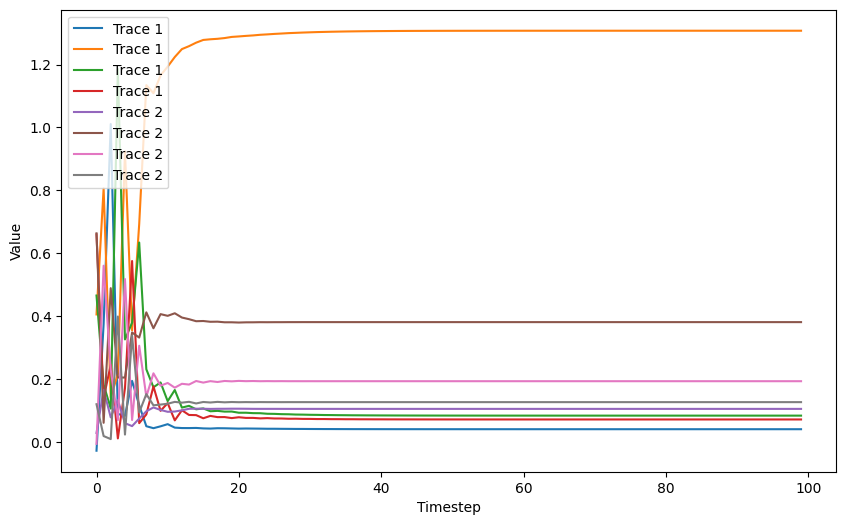

In [69]:
import matplotlib.pyplot as plt

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

# Example Training

## Simple Data Generation

In [70]:
import numpy as np
import torch

def generate_normalized_multivariate_time_series(n_features, total_length, amplitude=1.0):
    t = np.linspace(0, 100 * np.pi, total_length)
    series = np.zeros((total_length, n_features))
    for i in range(n_features):
        series[:, i] = amplitude * np.cos(t * (i + 1) / n_features) + 10
    
    # Normalize such that each timestep's values sum to 1
    series_sum = np.sum(series, axis=1, keepdims=True)
    series_normalized = series / series_sum
    
    return series_normalized

def segment_time_series(series, length):
    # Assuming series is a numpy array of shape [total_length, n_features]
    total_length, n_features = series.shape
    segments = []
    for start in range(0, total_length - length, length):
        segment = series[start:start + length]
        segments.append(segment)
    return np.stack(segments)


In [71]:
n_features = 4
length = 64  # Segment length
total_length = 1024  # Arbitrary total length for the generated series

# Generate and segment the time series
series = generate_normalized_multivariate_time_series(n_features, total_length)
series_x = series[:-1,]
series_y = series[1:,]

segments_x = segment_time_series(series_x, length)
segments_y = segment_time_series(series_y, length)

# Convert to tensors
segments_tensor_x = torch.tensor(segments_x, dtype=torch.float)
segments_tensor_y = torch.tensor(segments_y, dtype=torch.float)

# Prepare inputs and targets
X = segments_tensor_x
# Shift segments to the right by one timestep to create the targets
Y =  segments_tensor_y


In [72]:
from torch import nn, optim

# Model
model = NeuralCoilLayer(
    n_features = n_features
)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 5000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    outputs, transition_tensor = model(X)
    loss = criterion(outputs, Y)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')


Epoch [10/5000], Loss: 0.0006325730355456471
Epoch [20/5000], Loss: 0.0002381307422183454
Epoch [30/5000], Loss: 0.00025229924358427525
Epoch [40/5000], Loss: 0.00021763419499620795
Epoch [50/5000], Loss: 0.00019782519666478038
Epoch [60/5000], Loss: 0.0001898040936794132
Epoch [70/5000], Loss: 0.00017947271408047527
Epoch [80/5000], Loss: 0.00017031135212164372
Epoch [90/5000], Loss: 0.00016174734628293663
Epoch [100/5000], Loss: 0.00015317118959501386
Epoch [110/5000], Loss: 0.0001446525420760736
Epoch [120/5000], Loss: 0.00013598725490737706
Epoch [130/5000], Loss: 0.00012725056149065495
Epoch [140/5000], Loss: 0.00011850894952658564
Epoch [150/5000], Loss: 0.00010987277346430346
Epoch [160/5000], Loss: 0.000101478784927167
Epoch [170/5000], Loss: 9.348944877274334e-05
Epoch [180/5000], Loss: 8.609321230323985e-05
Epoch [190/5000], Loss: 7.950481085572392e-05
Epoch [200/5000], Loss: 7.385020580841228e-05
Epoch [210/5000], Loss: 6.90394954290241e-05
Epoch [220/5000], Loss: 6.48485001

In [79]:
import plotly.graph_objects as go

def plot_model_output_vs_target(model_outputs, targets, batch_index=0, feature_index=0):
    # Extract the specified feature for the given batch from both the model outputs and targets
    model_output_series = model_outputs[batch_index, :, feature_index].detach().numpy()
    target_series = targets[batch_index, :, feature_index].numpy()
    
    # Create a range for the x-axis (timesteps)
    timesteps = list(range(model_output_series.shape[0]))
    
    # Create traces
    model_trace = go.Scatter(x=timesteps, y=model_output_series, mode='lines', name='Model Output')
    target_trace = go.Scatter(x=timesteps, y=target_series, mode='lines', name='Target')
    
    # Create the figure and add traces
    fig = go.Figure()
    fig.add_trace(model_trace)
    fig.add_trace(target_trace)
    
    # Add title and labels
    fig.update_layout(title=f'Model Output vs Target for Feature {feature_index}, Batch {batch_index}',
                      xaxis_title='Timestep',
                      yaxis_title='Value')
    
    # Show the figure
    fig.show()

# Assuming `y` and `Y` are your model outputs and targets, respectively
# Adjust batch_index and feature_index as needed
plot_model_output_vs_target(outputs, Y, batch_index=3, feature_index=1)


tensor(1., grad_fn=<AddBackward0>)
tensor(1.0000, grad_fn=<AddBackward0>)
tensor(1., grad_fn=<AddBackward0>)
tensor(1., grad_fn=<AddBackward0>)
tensor(1.0000, grad_fn=<AddBackward0>)
tensor(1., grad_fn=<AddBackward0>)
tensor(1.0000, grad_fn=<AddBackward0>)
tensor(1.0000, grad_fn=<AddBackward0>)
tensor(1.0000, grad_fn=<AddBackward0>)
tensor(1., grad_fn=<AddBackward0>)
tensor(1., grad_fn=<AddBackward0>)
tensor(1.0000, grad_fn=<AddBackward0>)
tensor(1.0000, grad_fn=<AddBackward0>)
tensor(1.0000, grad_fn=<AddBackward0>)
tensor(1.0000, grad_fn=<AddBackward0>)
tensor(1.0000, grad_fn=<AddBackward0>)
tensor(1.0000, grad_fn=<AddBackward0>)
tensor(1.0000, grad_fn=<AddBackward0>)
tensor(1., grad_fn=<AddBackward0>)
tensor(1., grad_fn=<AddBackward0>)
tensor(1.0000, grad_fn=<AddBackward0>)
tensor(1., grad_fn=<AddBackward0>)
tensor(1.0000, grad_fn=<AddBackward0>)
tensor(1., grad_fn=<AddBackward0>)
tensor(1., grad_fn=<AddBackward0>)
tensor(1., grad_fn=<AddBackward0>)
tensor(1.0000, grad_fn=<AddBackwar

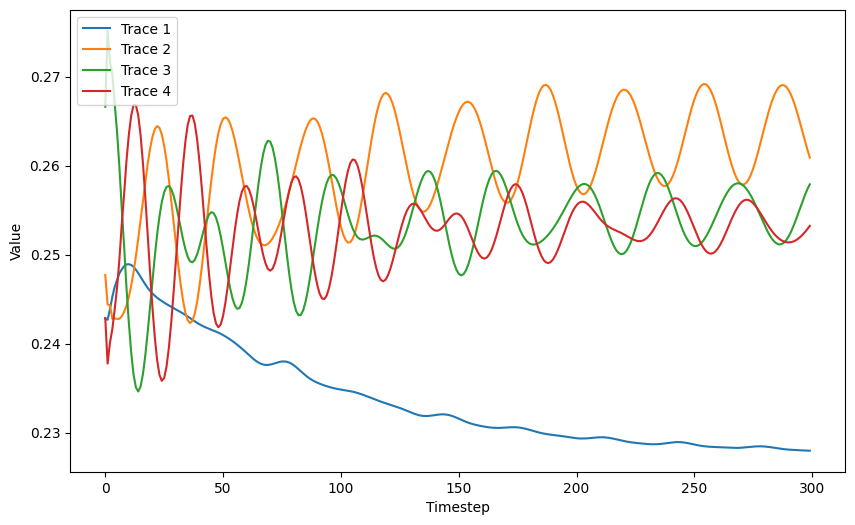

In [94]:
states = []
batch = 3
state_tensor = X[:,0,:]
batch_size = 15
transition_tensor = torch.zeros(batch_size, n_features, n_features)
for step_state in range(300):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    states.append(state_tensor[batch,:])
    print(sum(state_tensor[batch,:]))
    

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()